## Motivating example (taken from stack overflow 2015)

**A**

Does a R package exist which implements a circular array or vector in the sense of FIFO?

Say we have this array:

2 4 7 1

When inserting a new observation(say 3) at position 1, I want the n-th element to be replaced with the n-1st element:

3 2 4 7

**B**

You could try c() and cut off the length of the result.
```R
x <- c(2, 4, 7, 1)
c(3, x)[1:length(x)]
# [1] 3 2 4 7
```
This method does not make any copies of x
```R
tracemem(x)
"<0x3cb5998>"
c(3, x)[1:length(x)]
3 2 4 7
untracemem(x)
```
The source code for append() looks like it might have some useful methods to try out as well.
```R
append
function (x, values, after = length(x)) 
 {
     lengx <- length(x)
     if (!after) 
        c(values, x)
     else if (after >= lengx) 
         c(x, values)
     else c(x[1L:after], values, x[(after + 1L):lengx])
 }
 <bytecode: 0x31ac490>
 <environment: namespace:base>
 ```

**A**

That came to my mind also, but I'm wondering if this is efficient for very large arrays which are updated at hight frequencies?

**B**

I don't see why it wouldn't be. These are all primitive functions

**A**

Isn't the array copied for each insertion?

**B**

Not from what I see from tracemem() (see edited post).

**C**

Well, **B**'s solution is most likely the way to go but if you're in an adventurous mood you can try Rexamine/DataStructures:
```R
> devtools::install_github("Rexamine/DataStructures")
> library(DataStructures)
> q <- queue_create()
> queue_empty(q)
[1] TRUE
> for (i in c(1, 7, 4, 2)) { queue_push(q, i) }
> queue_empty(q)
[1] FALSE
> queue_pop(q)
[1] 1
> format(q)
[1] "7" "4" "2"
> queue_push(q, 3)
```

Hard to say if it stable enough to be used in practice though and it seems to be only marginally faster than a simple concatenation.

## What is the complexity of the suggested solution ?

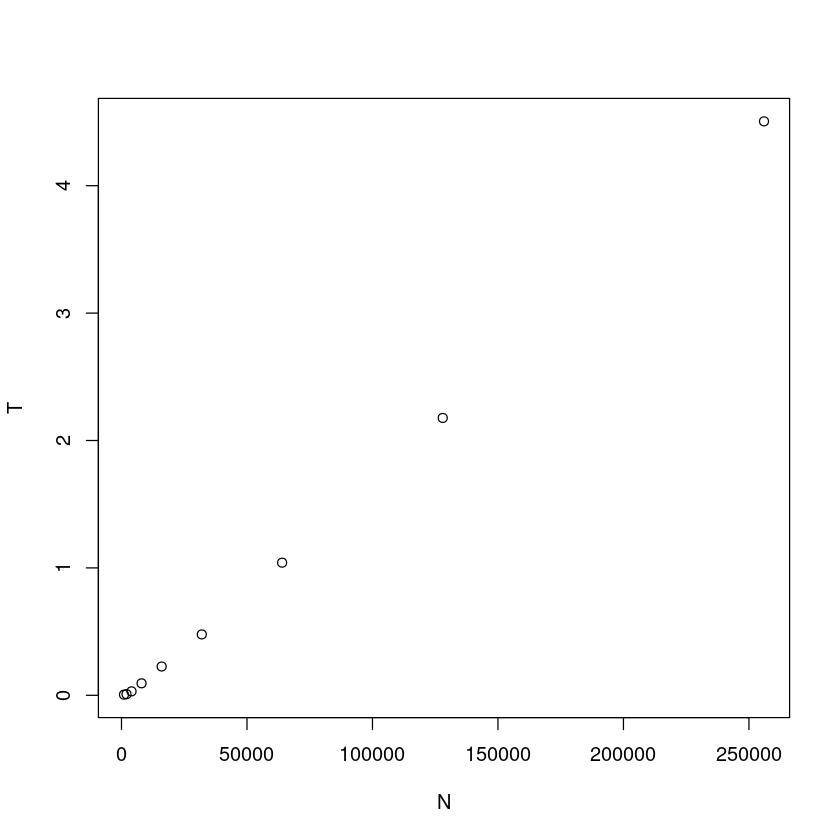

In [177]:
library(tictoc)
m <- 5000
k <- 8
N <- Map(function(n) 1000*2^n,0:k)
T <- c()
for(n in N)
{
    cbuffer <- rnorm(n,0,1)
    data <- rnorm(m,0,1)
    tic(quiet=TRUE)
    for(x in data)
    {
        cbuffer <- c(x,cbuffer)[2:length(cbuffer)]
    }
    res <- toc(quiet=TRUE)
    t <- as.numeric(res$toc - res$tic)
    T <- c(T,t)
}
plot(N,T)

The first characteristic of **R** that is important to be aware of is that vectors are _homogenous containers_ of _primitive types_. The primitive types are **double**<sup>1</sup>, **integer**, **character**, **logical**, **complex**, and **factor**. The automatic conversion rules between types stored in a vector are also important to understand, particularly given that the vector may be copied when conversion takes place. (**NB** - *need to check what actually happens* !) 

<sup>1</sup>**double** and the type **numeric** are synomynous in **R**.



In [131]:
circular_buffer <- function(size,type=double)
    {
      e <- new.env()
      e$buffer <- type(size)
      e$front <- e$back <- NULL
      class(e) <- "circular_buffer"
      return(e)
    }

In [134]:
setClass("circular_buffer")

In [135]:
setGeneric("push_back", function(object,value) {
  standardGeneric("push_back")
})

[1] "push_back"

In [174]:
setMethod("push_back", signature(object = "circular_buffer"), function(object,value) 
{
    if(is.null(object$front))
    {
        object$front <- object$back <- 0L
    }
    else
    {
        object$back <- (object$back + 1L)%%length(object$buffer)
        if(object$back == object$front)
        {
            object$front <- (object$front + 1L)%%length(object$buffer)
        }
    }
    object$buffer[object$back + 1L] <- value
    return(object)
})

In [160]:
is.integer(length(cb$buffer))

[1] TRUE

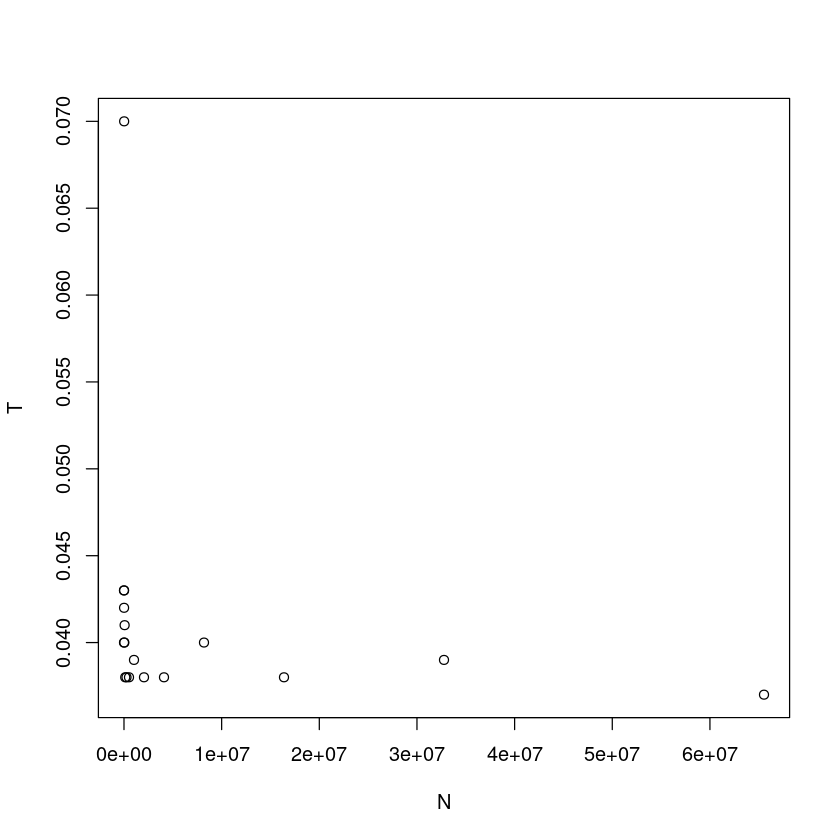

In [180]:
library(tictoc)
m <- 5000
k <- 16
N <- Map(function(n) 1000*2^n,0:k)
T <- c()
for(n in N)
{
    cbuffer <- circular_buffer(m,double)
    data <- rnorm(m,0,1)
    tic(quiet=TRUE)
    for(x in data)
    {
        cbuffer <- push_back(cbuffer,x)
    }
    res <- toc(quiet=TRUE)
    t <- as.numeric(res$toc - res$tic)
    T <- c(T,t)
}
plot(N,T)

In [181]:
cbuffer$buffer[1:10]

[1]  0.96299866  0.65821953  0.11514425  0.82474291 -0.04628683  0.30977265
 [7]  0.32316204  0.74833187  2.84129091  0.84927160

## Iteration

In [182]:
setClass("circular_buffer_iterator")
setGeneric("iterator", function(object) {
  standardGeneric("iterator")
})

[1] "iterator"

In [183]:
setMethod("iterator", signature(object = "circular_buffer"), function(object) 
{
    e <- new.env()
    e$object <- object
    e$cursor <- object$front
    class(e) <- "circular_buffer"
    return(e)
})

In [184]:
iterator(cbuffer)

[1] "hello from iterator for type circular_buffer"


In [203]:
setClass("get_next")
setGeneric("get_next", function(object) {
  standardGeneric("get_next")
})

[1] "get_next"

In [186]:
setMethod("get_next", signature(object = "get_"), function(object) 
{
    e <- new.env()
    e$object <- object
    e$cursor <- object$front
    class(e) <- "circular_buffer"
    return(e)
})

ERROR: Error in eval(expr, envir, enclos): no loop for break/next, jumping to top level


In [ ]:
circular_buffer_iterator <- function(size,type=double)
    {
      e <- new.env()
      e$buffer <- type(size)
      e$front <- e$back <- NULL
      class(e) <- "circular_buffer"
      return(e)
    }

In [199]:
setGeneric("+")

[1] "+"

In [205]:
getGeneric("[<-")

new("standardGeneric", .Data = function (x, i, j, ..., value) 
standardGeneric("[<-", .Primitive("[<-")), generic = "[<-", package = "base", 
    group = list(), valueClass = character(0), signature = c("x", 
    "i", "j", "value"), default = .Primitive("[<-"), skeleton = .Primitive("[<-")(x, 
        i, j, ..., value = value))
<bytecode: 0x563ce59d1810>
<environment: 0x563ce59cbc28>
attr(,"generic")
[1] "[<-"
attr(,"generic")attr(,"package")
[1] "base"
attr(,"package")
[1] "base"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "x"     "i"     "j"     "value"
attr(,"default")
.Primitive("[<-")
attr(,"skeleton")
.Primitive("[<-")(x, i, j, ..., value = value)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

In [201]:
setMethod("[<-",signature("circular_buffer_iterator"),
          function(x,i,j,...) {print("hello from [<- for types cb,cb")})

In [202]:
cbuffer+cbuffer

ERROR: Error in cbuffer + cbuffer: non-numeric argument to binary operator
